## DS 7337 - Natural Language Processing

### Author: Brandon Croom

### Homework: 6

### Assignment Criteria:

1.	Evaluate text similarity of Amazon book search results by doing the following:
 * Do a book search on Amazon. Manually copy the full book title (including subtitle) of each of the top 24 books listed in the first two pages of search results. 
 * In Python, run one of the text-similarity measures covered in this course, e.g., cosine similarity. Compare each of the book titles, pairwise, to every other one. 
 * Which two titles are the most similar to each other? Which are the most dissimilar? Where do they rank, among the first 24 results?

2.	Now evaluate using a major search engine.
 * Enter one of the book titles from question 1a into Google, Bing, or Yahoo!. Copy the capsule of the first organic result and the 20th organic result. Take web results only (i.e., not video results), and skip sponsored results. 
 * Run the same text similarity calculation that you used for question 1b on each of these capsules in comparison to the original query (book title). 
 * Which one has the highest similarity measure? 
 
Submit all of your inputs and outputs and your code for this assignment, along with a brief written explanation of your findings. 



In [70]:
# import libraries 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import nltk
import string
from nltk.stem import LancasterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

%matplotlib inline
pd.options.display.max_colwidth=500

In [48]:
# define our helper functions:
# tokenize text
def tokenize_text(book_text):
    TOKEN_PATTERN = r'\s+'
    regex_wt = nltk.RegexpTokenizer(pattern=TOKEN_PATTERN, gaps=True)
    word_tokens = regex_wt.tokenize(book_text)
    return word_tokens

# remove characters after tokenization
def remove_characters_after_tokenization(tokens):
    pattern = re.compile('[{}]'.format(re.escape(string.punctuation)))
    filtered_tokens = filter(None, [pattern.sub('', token) for token in tokens])
    return filtered_tokens

# convert tokens to lowercase
def convert_to_lowercase(tokens):
    return [token.lower() for token in tokens if token.isalpha()]

# remove token stopwords
def remove_stopwords(tokens):
    stopword_list = nltk.corpus.stopwords.words('english')
    filtered_tokens = [token for token in tokens if token not in stopword_list]
    return filtered_tokens

# apply lemmatization to tokens
def apply_lemmatization(tokens, wnl=WordNetLemmatizer()):
    return [wnl.lemmatize(token) for token in tokens]

# clean the text book lists by performing tokenization, text clean up
# and lemmatization
def cleanTextBooks(book_texts):
    clean_books = []
    for book in book_texts:
        book_i = tokenize_text(book)
        book_i = remove_characters_after_tokenization(book_i)
        book_i = convert_to_lowercase(book_i)
        book_i = remove_stopwords(book_i)
        book_i = apply_lemmatization(book_i)
        clean_books.append(book_i)
    return clean_books

# plot a heat map of the cosine similarity
def plot_heatmap(df_hm, xlabels, ylabels):
    sns.set(style="white")

    # Set up the matplotlib figure
    # (to enlarge the cells, increase the figure size)
    f, ax = plt.subplots(figsize=(18, 18))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 20, as_cmap=True)

    # Generate a mask for the upper triangle
    mask = np.zeros_like(df_hm, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(df_hm, mask=mask, cmap=cmap, center=0.5,
            xticklabels=xlabels, yticklabels=ylabels,
            square=True, linewidths=.5, fmt='.2f',
            annot=True, cbar_kws={"shrink": .5}, vmax=1)

    ax.set_title("Heatmap of cosine similarity scores").set_fontsize(15)
    ax.set_xlabel("")
    ax.set_ylabel("")

    return ax

# compute the cosine similarity of the pairwise comparisons
def compute_cosine_similarity(pair):

    # extract the indexes from the pair
    book1, book2 = pair

    # split on _ and get index
    book1_index = int(book1.split("_")[1])
    book2_index = int(book2.split("_")[1])

    # get the feature matrix of the document
    book1_fm = feature_matrix.toarray()[book1_index]
    book2_fm = feature_matrix.toarray()[book2_index]

    # compute cosine similarity manually
    manual_cosine_similarity = np.dot(book1_fm, book2_fm)

    return manual_cosine_similarity

1.	Evaluate text similarity of Amazon book search results by doing the following:
 * Do a book search on Amazon. Manually copy the full book title (including subtitle) of each of the top 24 books listed in the first two pages of search results. 
 * In Python, run one of the text-similarity measures covered in this course, e.g., cosine similarity. Compare each of the book titles, pairwise, to every other one. 
 * Which two titles are the most similar to each other? Which are the most dissimilar? Where do they rank, among the first 24 results?

In [76]:
# Build out the list of titles. Listing based on search for "Fun Books"
d0 = "True Facts that Sound Like Bulls#*t: 500 Insane-But-True Facts That Will Shock And Impress Your Friends"
d1 = "F*ck I'm Bored! Activity Book For Adults"
d2 = "Such a Fun Age"
d3 = "Wreck This Journal: Now in Color"
d4 = "What If?: Serious Scientific Answers to Absurd Hypothetical Questions"
d5 = "The Fun and Relaxing Adult Activity Book: With Easy Puzzles, Coloring Pages, Writing Activities, Brain Games and Much More"
d6 = "Now I Know: The Revealing Stories Behind the World's Most Interesting Facts"
d7 = "1144 Random, Interesting & Fun Facts You Need To Know - The Knowledge Encyclopedia To Win Trivia (Amazing World Facts Book 1)"
d8 = "Good Clean Fun: Misadventures in Sawdust at Offerman Woodshop"
d9 = "The Captain Underpants Extra-Crunchy Book o' Fun"
d10 = "3666 Interesting, Fun And Crazy Facts You Won't Believe Are True - The Knowledge Encyclopedia To Win Trivia (Amazing World Facts Book Book 4)"
d11 = "Would You Rather Book For Kids: The Book of Silly Scenarios, Challenging Choices, and Hilarious Situations the Whole Family Will Love (Game Book Gift Ideas)"
d12 = "Cat Butt Coloring Book: A Hilarious Fun Coloring Gift Book for Cat Lovers & Adults Relaxation with Stress Relieving Cat Butts Designs and Funny Cute Cat Quotes"
d13 = "Fun & Funky Coloring Book Treasury: Designs to Energize and Inspire (Design Originals) 208 Pages with 96 Groovy One-Side-Only Designs on Extra-Thick Perforated Paper in a Handy Spiral Lay-Flat Binding"
d14 = "399 Games, Puzzles & Trivia Challenges Specially Designed to Keep Your Brain Young."
d15 = "Why Should White Guys Have All the Fun?: How Reginald Lewis Created a Billion-Dollar Business Empire"
d16 = "Fun in the Tub: Creating Bath Bombs, Solid Bubble Bath, Bubble Frosting and Bubble Scoops"
d17 = "Drinking Animals Coloring Book: A Fun Coloring Gift Book for Party Lovers & Adults Relaxation with Stress Relieving Animal Designs, Quick and Easy Cocktail Recipes"
d18 = "Mind = Blown: Amazing Facts About This Weird, Hilarious, Insane World"
d19 = "Boba: Classic, Fun, and Refreshing Bubble Teas to Make at Home"
d20 = "Random Illustrated Facts: A Collection of Curious, Weird, and Totally Not Boring Things to Know"
d21 = "The Big Book of Random Facts Volume 2: 1000 Interesting Facts And Trivia (Interesting Trivia and Funny Facts)"
d22 = "That Sounds Fun: The Joys of Being an Amateur, the Power of Falling in Love, and Why You Need a Hobby"
d23 = "Coloring Books for Adults Relaxation: Swear Word Animal Designs: Sweary Book, Swear Word Coloring Book Patterns For Relaxation, Fun, and Relieve Your Stress (Volume 5)"
d24 = "Brain Games - Summer Fun Puzzles: Relax, Unwind, and Give Your Brain a Vacation"

book_titles = [d0,d1,d2,d3,d4,d5,d6,d7,d8,d9,d10,d11,d12,d13,d14,d15,d16,d17,d18,d19,d20,d21,d22,d23,d24]

In [77]:
# build generic listing of books so we can build out a titles
bookids_vals = ["book_" + str(i) for i in range(len(book_titles))]

# create a dictionary of the values
book_dict = dict(zip(bookids_vals, book_titles))

# grab all of the ids in the list so we can do pairwise comparison
book_ids = list(book_dict.keys())

# create a listing of all possible pairs
# we want to filter out any self-compares and any duplicate comparisons
book_pairs = []

for i, v in enumerate(book_ids):
    for j in book_ids[i+1:]:
        book_pairs.append((book_ids[i],j))

# Look at our book pairs to see if they make sense
print("Total book pairs: ", str(len(book_pairs)))
print("FIrst 10 pairs: ", book_pairs[:10])


Total book pairs:  300
FIrst 10 pairs:  [('book_0', 'book_1'), ('book_0', 'book_2'), ('book_0', 'book_3'), ('book_0', 'book_4'), ('book_0', 'book_5'), ('book_0', 'book_6'), ('book_0', 'book_7'), ('book_0', 'book_8'), ('book_0', 'book_9'), ('book_0', 'book_10')]


In [78]:
# clean the list of book to make them consistent
# cleanTextBooks returns a list of lists
clean_books = cleanTextBooks(book_titles)

# convert the list of lists to a list of strings
norm_clean_books = [' '.join(text) for text in clean_books]

print(norm_clean_books)

['true fact sound like bullst insanebuttrue fact shock impress friend', 'fck im bored activity book adult', 'fun age', 'wreck journal color', 'serious scientific answer absurd hypothetical question', 'fun relaxing adult activity book easy puzzle coloring page writing activity brain game much', 'know revealing story behind world interesting fact', 'random interesting fun fact need know knowledge encyclopedia win trivia amazing world fact book', 'good clean fun misadventure sawdust offerman woodshop', 'captain underpants extracrunchy book fun', 'interesting fun crazy fact wont believe true knowledge encyclopedia win trivia amazing world fact book book', 'would rather book kid book silly scenario challenging choice hilarious situation whole family love game book gift idea', 'cat butt coloring book hilarious fun coloring gift book cat lover adult relaxation stress relieving cat butt design funny cute cat quote', 'fun funky coloring book treasury design energize inspire design original page

In [46]:
vectorizer = TfidfVectorizer(min_df=0.0, max_df=1.0, ngram_range=(1,1))

# calculate the feature matrix
feature_matrix = vectorizer.fit_transform(norm_clean_books).astype(float)

# display the shape of feature matrix
display(feature_matrix.shape)

# display the first feature vector
display(feature_matrix[0])

# display the dense version of the feature vector
display(feature_matrix.toarray()[0])

# display the shape of dense feature vector
display(feature_matrix.toarray()[0].shape)

# display the first document text
display(norm_clean_books[0])

(25, 99)

<1x99 sparse matrix of type '<class 'numpy.float64'>'
	with 7 stored elements in Compressed Sparse Row format>

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.38389306, 0.        , 0.38389306, 0.        ,
       0.        , 0.        , 0.38389306, 0.        , 0.        ,
       0.34023038, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.38389306, 0.        , 0.        ,
       0.        , 0.38389306, 0.38389306, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

(99,)

'much never enough family created dangerous man'

In [79]:
# compute the pairwise cosine similarity for each pair to book titles
pairwise_cosine_similarity = [compute_cosine_similarity(pair) for pair in book_pairs]

# create a dataframe and display the head and tail to make sure everyting is captured
df = pd.DataFrame({'pair': book_pairs, 'similarity': pairwise_cosine_similarity})
display(df.head())
display(df.tail())

,pair,similarity
0,"(book_0, book_1)",0.0
1,"(book_0, book_2)",0.0
2,"(book_0, book_3)",0.0
3,"(book_0, book_4)",0.0
4,"(book_0, book_5)",0.0


,pair,similarity
295,"(book_21, book_23)",0.0
296,"(book_21, book_24)",0.0
297,"(book_22, book_23)",0.0
298,"(book_22, book_24)",0.0
299,"(book_23, book_24)",0.0


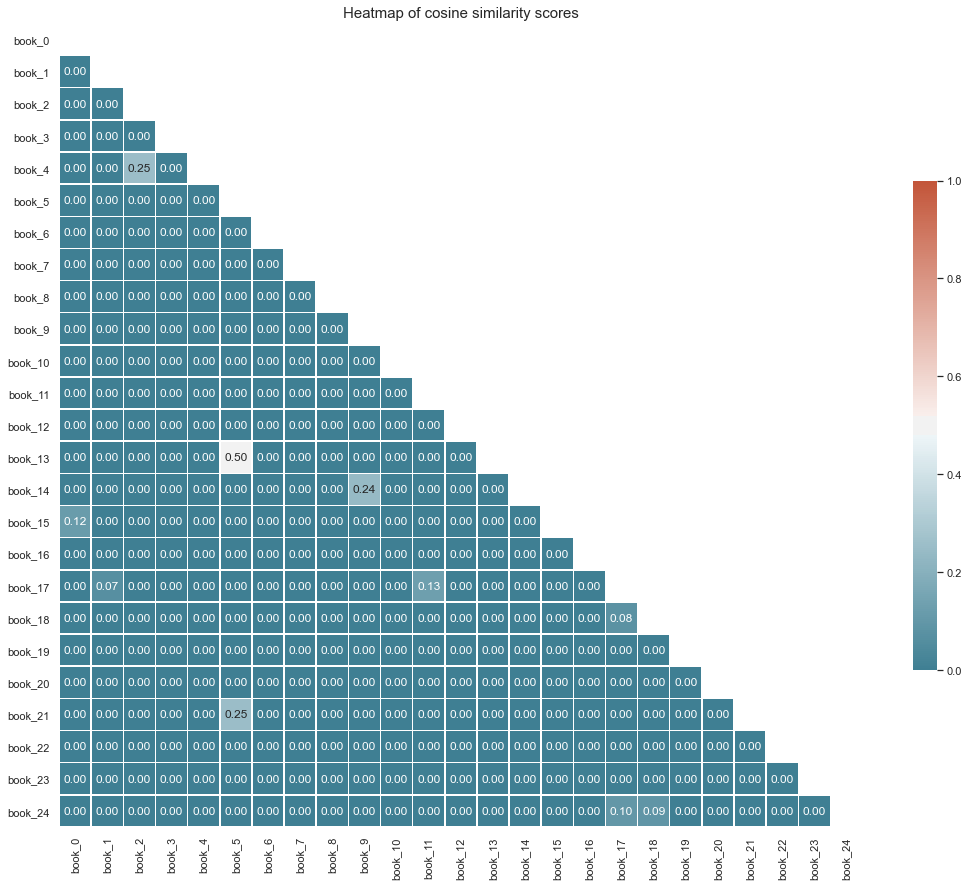

In [80]:
# initialize an empty dataframe grid based on the length of book titles
df_hm = pd.DataFrame({'ind': range(len(book_titles)), 'cols': range(len(book_titles)), 'vals': pd.Series(np.zeros(len(book_titles)))})

# convert to a matrix for the heatmap
df_hm = df_hm.pivot(index='ind', columns='cols').fillna(0)

# make a copy
df_temp = df.copy()

# convert list of tuples into 2 lists
list1 = []
list2 = []
for item1, item2 in df_temp.pair:
    list1.append(item1)
    list2.append(item2)

# add two columns to df_temp
df_temp['book1'] = list1
df_temp['book2'] = list2

# drop the pair as it not needed
df_temp.drop('pair', axis=1, inplace=True)

# extract index so that you can construct pairs
df_temp['book1'] = df_temp['book1'].apply(lambda x: int(x.split('_')[-1]))
df_temp['book2'] = df_temp['book2'].apply(lambda x: int(x.split('_')[-1]))

# create tuples (0, 1, similarity)
df_temp['pairs'] = list(zip(df_temp.book1, df_temp.book2, round(df_temp.similarity, 2)))

# to get lower diagonal, swap the rows and cols.
for row, col, similarity in df_temp.pairs:
    df_hm.iloc[col, row] = similarity

ax = plot_heatmap(df_hm, book_ids, book_ids)

### Question 1 - Analysis
From the heatmap above we can see a large majority of the titles have no cosine similarities between them. Book 5 ("The Fun and Relaxing Adult Activity Book: With Easy Puzzles, Coloring Pages, Writing Activities, Brain Games and Much More") and Book 13 ("Fun & Funky Coloring Book Treasury: Designs to Energize and Inspire (Design Originals) 208 Pages with 96 Groovy One-Side-Only Designs on Extra-Thick Perforated Paper in a Handy Spiral Lay-Flat Binding") have the highest cosine similarity. There is also similarity between book 5 and book 21 ("The Big Book of Random Facts Volume 2: 1000 Interesting Facts And Trivia (Interesting Trivia and Funny Facts)") at 0.25. Book 3 and Book 4 also have a 0.25 cosine similarity. 

### Question 2

Now evaluate using a major search engine.
 * Enter one of the book titles from question 1a into Google, Bing, or Yahoo!. Copy the capsule of the first organic result and the 20th organic result. Take web results only (i.e., not video results), and skip sponsored results. 
 * Run the same text similarity calculation that you used for question 1b on each of these capsules in comparison to the original query (book title). 
 * Which one has the highest similarity measure? 

Using the book title: "What If?: Serious Scientific Answers to Absurd Hypothetical Questions" in a google search results in the following first and 20th entry:

1 - What If?: Serious Scientific Answers to Absurd ... - Amazon.comwww.amazon.com › What-If-Scientific-Hypothetical-Q...
What If?: Serious Scientific Answers to Absurd Hypothetical Questions Kindle Edition. by ...

20 - 
What If?: Serious Scientific Answers to Absurd Hypothetical ...books.google.com › books › about › What_If
Title, What If?: Serious Scientific Answers to Absurd Hypothetical Questions. Author, Randall Munroe. Edition, illustrated. Publisher, John Murray, an Hachette ...

In [118]:
# Compare the first search entry to the book
search1 = "What If?: Serious Scientific Answers to Absurd ... - Amazon.comwww.amazon.com › What-If-Scientific-Hypothetical-Q... What If?: Serious Scientific Answers to Absurd Hypothetical Questions Kindle Edition. by ..."
#search20 = "What If?: Serious Scientific Answers to Absurd Hypothetical ...books.google.com › books › about › What_If Title, What If?: Serious Scientific Answers to Absurd Hypothetical Questions. Author, Randall Munroe. Edition, illustrated. Publisher, John Murray, an Hachette ..."
book = "What If?: Serious Scientific Answers to Absurd Hypothetical Questions"

search_list = [search1,book]

# build generic listing of books so we can build out a dictionary
searchID_vals = ["search_" + str(i) for i in range(len(search_list))]

# create a dictionary of the values
search_dict = dict(zip(searchID_vals, search_list))

# grab all of the ids in the list so we can do pairwise comparison
search_ids = list(search_dict.keys())

# create a listing of all possible pairs
# we want to filter out any self-compares and any duplicate comparisons
search_pairs = []

for i, v in enumerate(search_ids):
    for j in search_ids[i+1:]:
        search_pairs.append((search_ids[i],j))

# Look at our search pairs to see if they make sense
print("Total search pairs: ", str(len(search_pairs)))

Total search pairs:  1


In [119]:
# clean the list of book to make them consistent
# cleanTextBooks returns a list of lists
clean_search = cleanTextBooks(search_list)

# convert the list of lists to a list of strings
norm_clean_search = [' '.join(text) for text in clean_search]

print(norm_clean_search)

['serious scientific answer absurd amazoncomwwwamazoncom whatifscientifichypotheticalq serious scientific answer absurd hypothetical question kindle edition', 'serious scientific answer absurd hypothetical question']


In [120]:
vectorizer = TfidfVectorizer(min_df=0.0, max_df=1.0, ngram_range=(1,1))

# calculate the feature matrix
feature_matrix = vectorizer.fit_transform(norm_clean_search).astype(float)

# display the shape of feature matrix
display(feature_matrix.shape)

# display the first feature vector
display(feature_matrix[0])

# display the dense version of the feature vector
display(feature_matrix.toarray()[0])

# display the shape of dense feature vector
display(feature_matrix.toarray()[0].shape)

# display the first document text
display(norm_clean_books[0])

(2, 10)

<1x10 sparse matrix of type '<class 'numpy.float64'>'
	with 10 stored elements in Compressed Sparse Row format>

array([0.39297867, 0.2761589 , 0.39297867, 0.2761589 , 0.19648933,
       0.2761589 , 0.19648933, 0.39297867, 0.39297867, 0.2761589 ])

(10,)

'true fact sound like bullst insanebuttrue fact shock impress friend'

In [121]:
# compute the pairwise cosine similarity for each pair to book titles
pairwise_cosine_similarity = [compute_cosine_similarity(pair) for pair in search_pairs]

# create a dataframe and display the head and tail to make sure everyting is captured
df = pd.DataFrame({'pair': search_pairs, 'similarity': pairwise_cosine_similarity})
display(df.head())
display(df.tail())

,pair,similarity
0,"(search_0, search_1)",0.802164


,pair,similarity
0,"(search_0, search_1)",0.802164


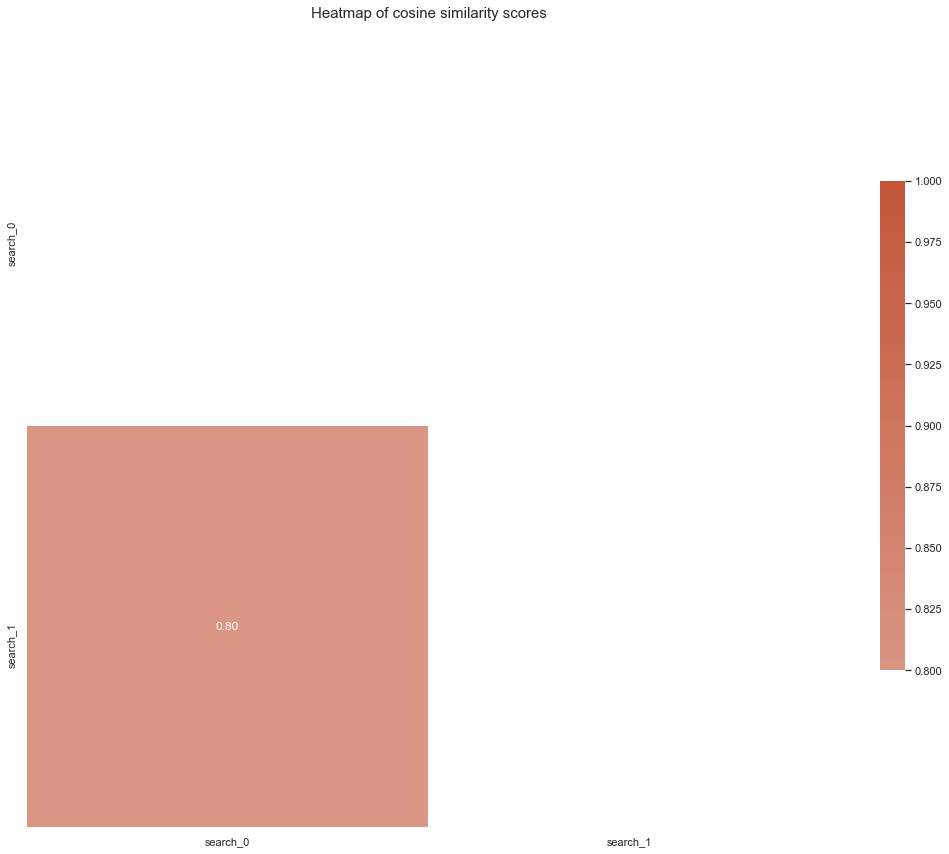

In [122]:
# initialize an empty dataframe grid based on the length of book titles
df_hm = pd.DataFrame({'ind': range(len(search_list)), 'cols': range(len(search_list)), 'vals': pd.Series(np.zeros(len(search_list)))})

# convert to a matrix for the heatmap
df_hm = df_hm.pivot(index='ind', columns='cols').fillna(0)

# make a copy
df_temp = df.copy()

# convert list of tuples into 2 lists
list1 = []
list2 = []
for item1, item2 in df_temp.pair:
    list1.append(item1)
    list2.append(item2)

# add two columns to df_temp
df_temp['search1'] = list1
df_temp['search2'] = list2

# drop the pair as it not needed
df_temp.drop('pair', axis=1, inplace=True)

# extract index so that you can construct pairs
df_temp['search1'] = df_temp['search1'].apply(lambda x: int(x.split('_')[-1]))
df_temp['search2'] = df_temp['search2'].apply(lambda x: int(x.split('_')[-1]))

# create tuples (0, 1, similarity)
df_temp['pairs'] = list(zip(df_temp.search1, df_temp.search2, round(df_temp.similarity, 2)))

# to get lower diagonal, swap the rows and cols.
for row, col, similarity in df_temp.pairs:
    df_hm.iloc[col, row] = similarity

ax = plot_heatmap(df_hm, search_ids, search_ids)

From the above heatmap we see that search 1 and the book title have a 0.80 cosine similarity

In [124]:
# Compare the 20th search entry to the book
#search1 = "What If?: Serious Scientific Answers to Absurd ... - Amazon.comwww.amazon.com › What-If-Scientific-Hypothetical-Q... What If?: Serious Scientific Answers to Absurd Hypothetical Questions Kindle Edition. by ..."
search20 = "What If?: Serious Scientific Answers to Absurd Hypothetical ...books.google.com › books › about › What_If Title, What If?: Serious Scientific Answers to Absurd Hypothetical Questions. Author, Randall Munroe. Edition, illustrated. Publisher, John Murray, an Hachette ..."
book = "What If?: Serious Scientific Answers to Absurd Hypothetical Questions"

search_list = [search20,book]

# build generic listing of books so we can build out a dictionary
searchID_vals = ["search_" + str(i) for i in range(len(search_list))]

# create a dictionary of the values
search_dict = dict(zip(searchID_vals, search_list))

# grab all of the ids in the list so we can do pairwise comparison
search_ids = list(search_dict.keys())

# create a listing of all possible pairs
# we want to filter out any self-compares and any duplicate comparisons
search_pairs = []

for i, v in enumerate(search_ids):
    for j in search_ids[i+1:]:
        search_pairs.append((search_ids[i],j))

# Look at our search pairs to see if they make sense
print("Total search pairs: ", str(len(search_pairs)))

Total search pairs:  1


In [125]:
# clean the list of book to make them consistent
# cleanTextBooks returns a list of lists
clean_search = cleanTextBooks(search_list)

# convert the list of lists to a list of strings
norm_clean_search = [' '.join(text) for text in clean_search]

print(norm_clean_search)

['serious scientific answer absurd hypothetical booksgooglecom book whatif title serious scientific answer absurd hypothetical question author randall munroe edition illustrated publisher john murray hachette', 'serious scientific answer absurd hypothetical question']


In [126]:
vectorizer = TfidfVectorizer(min_df=0.0, max_df=1.0, ngram_range=(1,1))

# calculate the feature matrix
feature_matrix = vectorizer.fit_transform(norm_clean_search).astype(float)

# display the shape of feature matrix
display(feature_matrix.shape)

# display the first feature vector
display(feature_matrix[0])

# display the dense version of the feature vector
display(feature_matrix.toarray()[0])

# display the shape of dense feature vector
display(feature_matrix.toarray()[0].shape)

# display the first document text
display(norm_clean_books[0])

(2, 19)

<1x19 sparse matrix of type '<class 'numpy.float64'>'
	with 19 stored elements in Compressed Sparse Row format>

array([0.29273034, 0.29273034, 0.20571114, 0.20571114, 0.20571114,
       0.20571114, 0.20571114, 0.29273034, 0.20571114, 0.20571114,
       0.20571114, 0.20571114, 0.20571114, 0.14636517, 0.20571114,
       0.29273034, 0.29273034, 0.20571114, 0.20571114])

(19,)

'true fact sound like bullst insanebuttrue fact shock impress friend'

In [127]:
# compute the pairwise cosine similarity for each pair to book titles
pairwise_cosine_similarity = [compute_cosine_similarity(pair) for pair in search_pairs]

# create a dataframe and display the head and tail to make sure everyting is captured
df = pd.DataFrame({'pair': search_pairs, 'similarity': pairwise_cosine_similarity})
display(df.head())
display(df.tail())

,pair,similarity
0,"(search_0, search_1)",0.657287


,pair,similarity
0,"(search_0, search_1)",0.657287


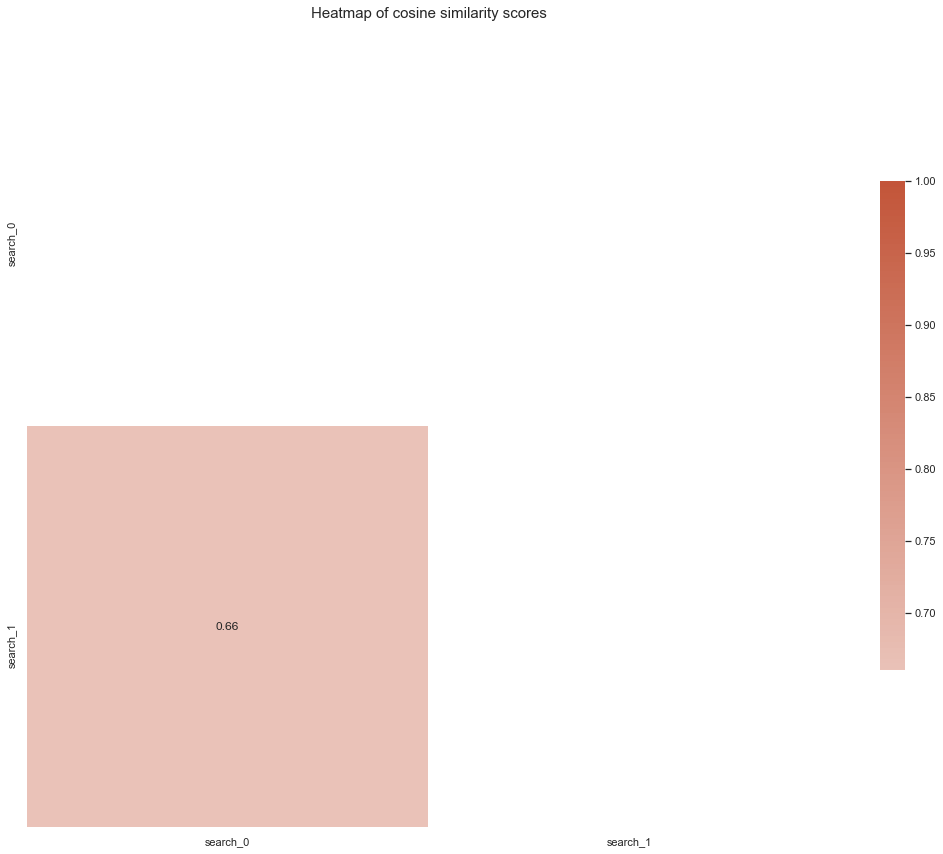

In [128]:
# initialize an empty dataframe grid based on the length of book titles
df_hm = pd.DataFrame({'ind': range(len(search_list)), 'cols': range(len(search_list)), 'vals': pd.Series(np.zeros(len(search_list)))})

# convert to a matrix for the heatmap
df_hm = df_hm.pivot(index='ind', columns='cols').fillna(0)

# make a copy
df_temp = df.copy()

# convert list of tuples into 2 lists
list1 = []
list2 = []
for item1, item2 in df_temp.pair:
    list1.append(item1)
    list2.append(item2)

# add two columns to df_temp
df_temp['search1'] = list1
df_temp['search2'] = list2

# drop the pair as it not needed
df_temp.drop('pair', axis=1, inplace=True)

# extract index so that you can construct pairs
df_temp['search1'] = df_temp['search1'].apply(lambda x: int(x.split('_')[-1]))
df_temp['search2'] = df_temp['search2'].apply(lambda x: int(x.split('_')[-1]))

# create tuples (0, 1, similarity)
df_temp['pairs'] = list(zip(df_temp.search1, df_temp.search2, round(df_temp.similarity, 2)))

# to get lower diagonal, swap the rows and cols.
for row, col, similarity in df_temp.pairs:
    df_hm.iloc[col, row] = similarity

ax = plot_heatmap(df_hm, search_ids, search_ids)

From the above heatmap we can see that the cosine similarity between the book and the 20th search is 0.66.

In [134]:
# Compare the 20th search entry to the first search entry
search1 = "What If?: Serious Scientific Answers to Absurd ... - Amazon.comwww.amazon.com › What-If-Scientific-Hypothetical-Q... What If?: Serious Scientific Answers to Absurd Hypothetical Questions Kindle Edition. by ..."
search20 = "What If?: Serious Scientific Answers to Absurd Hypothetical ...books.google.com › books › about › What_If Title, What If?: Serious Scientific Answers to Absurd Hypothetical Questions. Author, Randall Munroe. Edition, illustrated. Publisher, John Murray, an Hachette ..."
#book = "What If?: Serious Scientific Answers to Absurd Hypothetical Questions"

search_list = [search1,search20]

# build generic listing of books so we can build out a dictionary
searchID_vals = ["search_" + str(i) for i in range(len(search_list))]

# create a dictionary of the values
search_dict = dict(zip(searchID_vals, search_list))

# grab all of the ids in the list so we can do pairwise comparison
search_ids = list(search_dict.keys())

# create a listing of all possible pairs
# we want to filter out any self-compares and any duplicate comparisons
search_pairs = []

for i, v in enumerate(search_ids):
    for j in search_ids[i+1:]:
        search_pairs.append((search_ids[i],j))

# Look at our search pairs to see if they make sense
print("Total search pairs: ", str(len(search_pairs)))

Total search pairs:  1


In [135]:
# clean the list of book to make them consistent
# cleanTextBooks returns a list of lists
clean_search = cleanTextBooks(search_list)

# convert the list of lists to a list of strings
norm_clean_search = [' '.join(text) for text in clean_search]

print(norm_clean_search)

['serious scientific answer absurd amazoncomwwwamazoncom whatifscientifichypotheticalq serious scientific answer absurd hypothetical question kindle edition', 'serious scientific answer absurd hypothetical booksgooglecom book whatif title serious scientific answer absurd hypothetical question author randall munroe edition illustrated publisher john murray hachette']


In [136]:
vectorizer = TfidfVectorizer(min_df=0.0, max_df=1.0, ngram_range=(1,1))

# calculate the feature matrix
feature_matrix = vectorizer.fit_transform(norm_clean_search).astype(float)

# display the shape of feature matrix
display(feature_matrix.shape)

# display the first feature vector
display(feature_matrix[0])

# display the dense version of the feature vector
display(feature_matrix.toarray()[0])

# display the shape of dense feature vector
display(feature_matrix.toarray()[0].shape)

# display the first document text
display(norm_clean_books[0])

(2, 22)

<1x22 sparse matrix of type '<class 'numpy.float64'>'
	with 10 stored elements in Compressed Sparse Row format>

array([0.40059335, 0.28150998, 0.40059335, 0.        , 0.        ,
       0.        , 0.20029667, 0.        , 0.20029667, 0.        ,
       0.        , 0.28150998, 0.        , 0.        , 0.        ,
       0.20029667, 0.        , 0.40059335, 0.40059335, 0.        ,
       0.        , 0.28150998])

(22,)

'true fact sound like bullst insanebuttrue fact shock impress friend'

In [137]:
# compute the pairwise cosine similarity for each pair to book titles
pairwise_cosine_similarity = [compute_cosine_similarity(pair) for pair in search_pairs]

# create a dataframe and display the head and tail to make sure everyting is captured
df = pd.DataFrame({'pair': search_pairs, 'similarity': pairwise_cosine_similarity})
display(df.head())
display(df.tail())

,pair,similarity
0,"(search_0, search_1)",0.592552


,pair,similarity
0,"(search_0, search_1)",0.592552


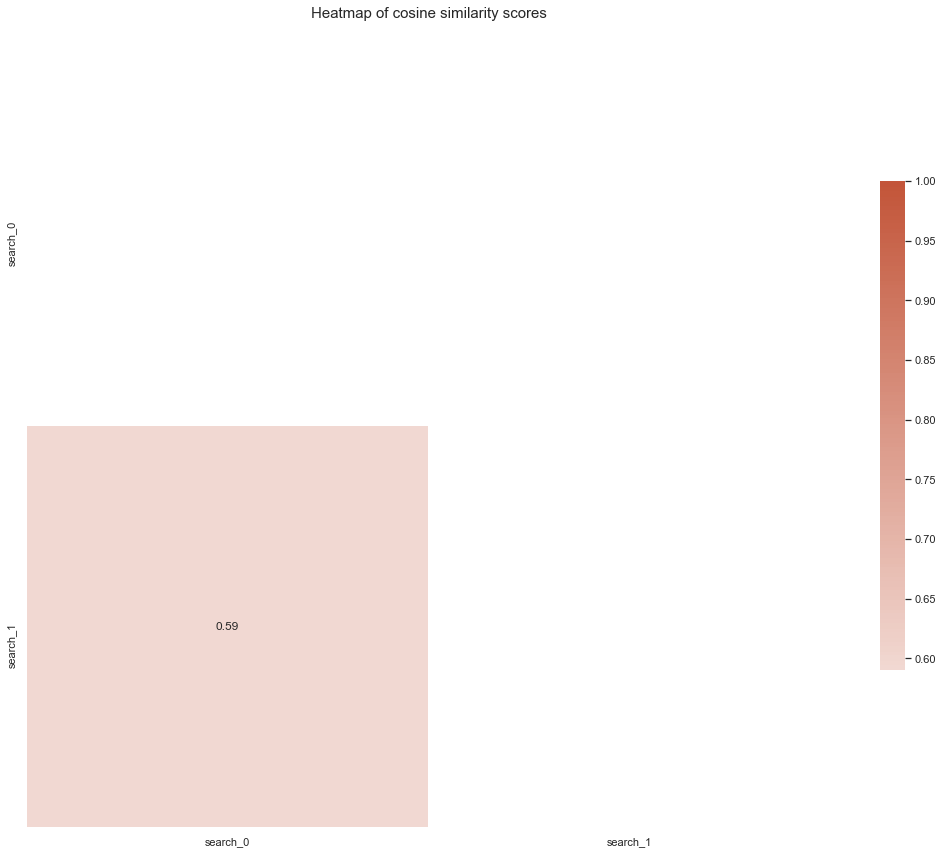

In [138]:
# initialize an empty dataframe grid based on the length of book titles
df_hm = pd.DataFrame({'ind': range(len(search_list)), 'cols': range(len(search_list)), 'vals': pd.Series(np.zeros(len(search_list)))})

# convert to a matrix for the heatmap
df_hm = df_hm.pivot(index='ind', columns='cols').fillna(0)

# make a copy
df_temp = df.copy()

# convert list of tuples into 2 lists
list1 = []
list2 = []
for item1, item2 in df_temp.pair:
    list1.append(item1)
    list2.append(item2)

# add two columns to df_temp
df_temp['search1'] = list1
df_temp['search2'] = list2

# drop the pair as it not needed
df_temp.drop('pair', axis=1, inplace=True)

# extract index so that you can construct pairs
df_temp['search1'] = df_temp['search1'].apply(lambda x: int(x.split('_')[-1]))
df_temp['search2'] = df_temp['search2'].apply(lambda x: int(x.split('_')[-1]))

# create tuples (0, 1, similarity)
df_temp['pairs'] = list(zip(df_temp.search1, df_temp.search2, round(df_temp.similarity, 2)))

# to get lower diagonal, swap the rows and cols.
for row, col, similarity in df_temp.pairs:
    df_hm.iloc[col, row] = similarity

ax = plot_heatmap(df_hm, search_ids, search_ids)

From the heatmap above we can see the the two search strings only have a 0.59 cosine similarity

### Question 2 Analysis:

Using the heatmaps and calculations above we can see that the first google search entry for the book "What If?: Serious Scientific Answers to Absurd Hypothetical Questions" had a cosine similarity of 0.80. Given that the first search entry was the actual listing at Amazon this logically makes sense. The 20th entry and the book have a cosine similarity of 0.66. This 20th result was a Google link result. In comparison to the first entry this similary score makes sense give that it's close to the book but not as close as the original link. The other interesting aspect of the analysis is the comparison between the two search strings. The two strings only have a 0.59 cosine similarity. The strings are similiar but not as similar to each other as they are to the book. We would expect this result as the differnent search entries contain different information. 